In [1]:
# libraries need for the code
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np

# Reading the data 
Alzheimers = pd.read_csv("alzheimers_disease_data.csv")

# removing the DoctorInCharge column - information from this column was not needed, and all of it was redacted
Alzheimers = Alzheimers.drop('DoctorInCharge', axis=1) # axis=1 is the setting to for dropping a column

# removing the PatientID column - information from this column was not needed, as it only serves as a numerical identifier 
Alzheimers = Alzheimers.drop('PatientID', axis=1) # axis=1 is the setting to for dropping a column

# Printing a summary of null values per column
print(Alzheimers.isnull().sum())

# removing any of the n/a values
Alzheimers = Alzheimers.dropna()

# showing 10 rows of the dataset after cleaning 
display(Alzheimers.head(10))

PatientID                    0
Age                          0
Gender                       0
Ethnicity                    0
EducationLevel               0
BMI                          0
Smoking                      0
AlcoholConsumption           0
PhysicalActivity             0
DietQuality                  0
SleepQuality                 0
FamilyHistoryAlzheimers      0
CardiovascularDisease        0
Diabetes                     0
Depression                   0
HeadInjury                   0
Hypertension                 0
SystolicBP                   0
DiastolicBP                  0
CholesterolTotal             0
CholesterolLDL               0
CholesterolHDL               0
CholesterolTriglycerides     0
MMSE                         0
FunctionalAssessment         0
MemoryComplaints             0
BehavioralProblems           0
ADL                          0
Confusion                    0
Disorientation               0
PersonalityChanges           0
DifficultyCompletingTasks    0
Forgetfu

Age  Gender  Ethnicity  EducationLevel        BMI  Smoking  \
0   73       0          0               2  22.927749        0   
1   89       0          0               0  26.827681        0   
2   73       0          3               1  17.795882        0   
3   74       1          0               1  33.800817        1   
4   89       0          0               0  20.716974        0   
5   86       1          1               1  30.626886        0   
6   68       0          3               2  38.387622        1   
7   75       0          0               1  18.776009        0   
8   72       1          1               0  27.833188        0   
9   87       0          0               0  35.456302        1   

   AlcoholConsumption  PhysicalActivity  DietQuality  SleepQuality  ...  \
0           13.297218          6.327112     1.347214      9.025679  ...   
1            4.542524          7.619885     0.518767      7.151293  ...   
2           19.555085          7.844988     1.826335      9.673574  ...   
3           12.209266          8.428001     7.435604      8.392554  ...   
4           18.454356          6.310461     0.795498      5.597238  ...   
5            4.140144          0.211062     1.584922      7.261953  ...   
6            0.646047          9.257695     5.897388      5.477686  ...   
7           13.723826          4.649451     8.341903      4.213210  ...   
8           12.167848          1.531360     6.736882      5.748224  ...   
9           16.028688          6.440773     8.086019      7.551773  ...   

   FunctionalAssessment  MemoryComplaints  BehavioralProblems       ADL  \
0              6.518877                 0                   0  1.725883   
1              7.118696                 0                   0  2.592424   
2              5.895077                 0                   0  7.119548   
3              8.965106                 0                   1  6.481226   
4              6.045039                 0                   0  0.014691   
5              5.510144                 0                   0  9.015686   
6              6.062124                 0                   0  9.236328   
7              3.401374                 0                   0  4.517248   
8              7.396061                 0                   1  0.756232   
9              1.148904                 0                   1  4.554394   

   Confusion  Disorientation  PersonalityChanges  DifficultyCompletingTasks  \
0          0               0                   0                          1   
1          0               0                   0                          0   
2          0               1                   0                          1   
3          0               0                   0                          0   
4          0               0                   1                          1   
5          1               0                   0                          0   
6          0               0                   0                          0   
7          1               0                   0                          0   
8          0               0                   1                          0   
9          0               0                   0                          0   

   Forgetfulness  Diagnosis  
0              0          0  
1              1          0  
2              0          0  
3              0          0  
4              0          0  
5              0          0  
6              1          0  
7              1          1  
8              0          0  
9              0          0  

[10 rows x 33 columns]

In [2]:
# libraries needed for clusters and scaling
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# numerical stabilizer added to prevent zero division
epsilon = 1e-5 

# CognitiveScore cluster
# averaging the functional cognitive assessments into a singular measuring metric
Alzheimers['CognitiveScore'] = (
    Alzheimers['MMSE'] + 
    Alzheimers['FunctionalAssessment'] + 
    (1 - Alzheimers['MemoryComplaints']) + 
    (1 - Alzheimers['BehavioralProblems']) + 
    Alzheimers['ADL']
) / 5

# standardizing the cognitive average metric with z-score normalization
# levels the score to the same scale pre-PCA
cognitive_features = ['MMSE', 'FunctionalAssessment', 'MemoryComplaints', 'BehavioralProblems', 'ADL']
X_cognitive = (Alzheimers[cognitive_features] - Alzheimers[cognitive_features].mean()) / Alzheimers[cognitive_features].std()

# PCA is applied 
# reduces standardized features into a singular principal component
# turns the cognitive metric into a singular dimension and summarizes it 
pca = PCA(n_components=1)
Alzheimers['CognitivePCA'] = pca.fit_transform(X_cognitive)

# removes the columns used to make the CognitiveScore cluster from the dataset
# prevents redundancy
Alzheimers = Alzheimers.drop(columns=cognitive_features)

# MetabolicRisk cluster
# factors all associated with metabolic syndrome
# BMI is multiplied by the sum of the other features 
# BMI is multiplied because it acts as an amplifier for the other conditions
# more condtions = higher BMI = overall worse metabolic risk
Alzheimers['MetabolicRisk'] = Alzheimers['BMI'] * (
    Alzheimers['Hypertension'] + 
    Alzheimers['Diabetes'] + 
    Alzheimers['CardiovascularDisease'] + 
    Alzheimers['CholesterolTriglycerides']
)

# removes the columns used to make the MetabolicRisk cluster from the dataset
# prevents redundancy
Alzheimers = Alzheimers.drop(columns=['BMI', 'Hypertension', 'Diabetes', 'CardiovascularDisease', 'CholesterolTriglycerides'], errors='ignore')

# Ratio Clusters
# epsilon prevents zero division and numerical imbalance 
# Cholesterol_Ratio divides bad cholesterol by good cholesterol 
# higher scores = worse level of cholesterol
Alzheimers['Cholesterol_Ratio'] = Alzheimers['CholesterolLDL'] / (Alzheimers['CholesterolHDL'] + epsilon)
# BP_Ratio = blood pressure reading
# measures risk of cardiovascular issues 
Alzheimers['BP_Ratio'] = Alzheimers['SystolicBP'] / (Alzheimers['DiastolicBP'] + epsilon)
# removes the columns used to make the Ratio cluster from the dataset
# prevents redundancy
Alzheimers = Alzheimers.drop(columns=['CholesterolLDL', 'CholesterolHDL', 'SystolicBP', 'DiastolicBP'], errors='ignore')

# standardizes the ratios with z-score normalization 
# puts the scores on the same level 
scaler = StandardScaler()
Alzheimers[['Cholesterol_Ratio', 'BP_Ratio']] = scaler.fit_transform(Alzheimers[['Cholesterol_Ratio', 'BP_Ratio']])

In [3]:
# absoltue correlation calcuation matrix between all features 
# looks at magnitude not direction of correlation
corr_matrix = Alzheimers.corr().abs()
# prevents rechecking of the same feature pair
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# removes features that have more than a 0.5 correlation with another feature 
to_drop = [column for column in upper.columns if any(upper[column] > 0.5)]

print("Features dropped due to high correlation:", to_drop)

# drops those highly correlated features from the dataset
Alzheimers = Alzheimers.drop(columns=to_drop)

Features dropped due to high correlation: ['CognitivePCA']


Optimization terminated successfully.
         Current function value: 0.539149
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              Diagnosis   No. Observations:                 1719
Model:                          Logit   Df Residuals:                     1696
Method:                           MLE   Df Model:                           22
Date:                Mon, 14 Apr 2025   Pseudo R-squ.:                  0.1697
Time:                        11:01:00   Log-Likelihood:                -926.80
converged:                       True   LL-Null:                       -1116.2
Covariance Type:            nonrobust   LLR p-value:                 9.252e-67
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         3.0341      0.671      4.521      0.000       1.

C:\Users\madis\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:01:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\madis\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:01:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Statistically significant features:
                      Feature    Importance
18             CognitiveScore  1.132558e-01
4                     Smoking  9.302326e-04
9     FamilyHistoryAlzheimers  4.651163e-04
16  DifficultyCompletingTasks  2.325581e-04
11                 HeadInjury  2.220446e-17
13                  Confusion -2.325581e-04
15         PersonalityChanges -4.651163e-04
17              Forgetfulness -1.627907e-03
7                 DietQuality -2.790698e-03
14             Disorientation -2.790698e-03
21                   BP_Ratio -3.488372e-03
2                   Ethnicity -4.883721e-03
19              MetabolicRisk -5.116279e-03
10                 Depression -6.046512e-03
12           CholesterolTotal -6.046512e-03
1                      Gender -6.279070e-03
3              EducationLevel -6.511628e-03
20          Cholesterol_Ratio -8.604651e-03
0                         Age -1.279070e-02
5          AlcoholConsumption -1.627907e-02
8                SleepQuality -2.209302

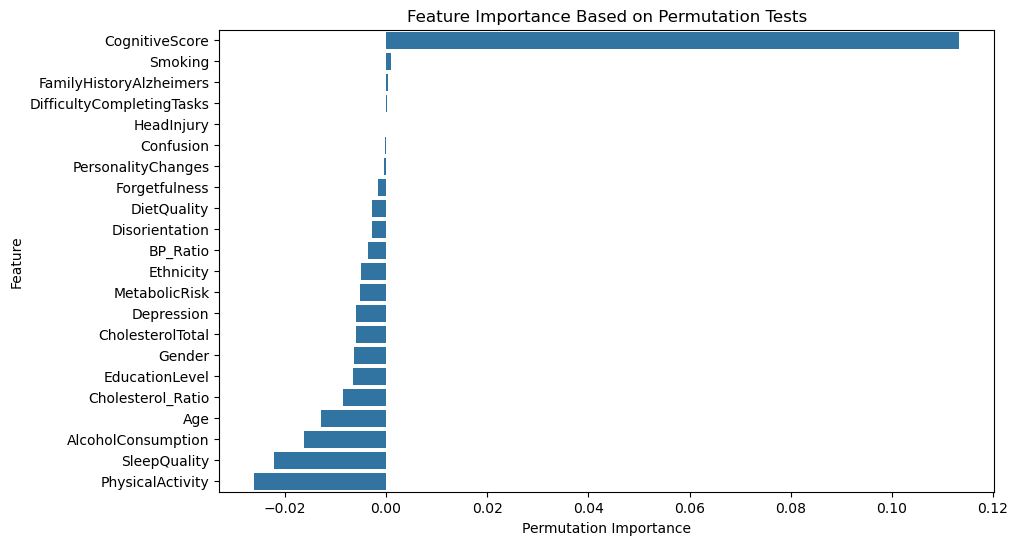

In [4]:
# libraries needed to run code 
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# separating features from Diagnosis
# dropping the target variable
X = Alzheimers.drop(columns=['Diagnosis'])
# setting target variable
y = Alzheimers['Diagnosis'] 
# splitting the data into train and test
# to be used in statistical evaluation and examining model validity 
X_train_stat, X_test_stat, y_train_stat, y_test_stat = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression Analysis with P-values
# Logistic regression is run to get the p-values per feature
# inserting an intercepting term 
X_const = sm.add_constant(X_train_stat)
# fitting the model
logit_model = sm.Logit(y_train_stat, X_const) 
result = logit_model.fit()
# displaying the p > |z| column 
# p-values < 0.05 = statistically significant 
print(result.summary())

# Continuous Feature T-Tests
# displays the features with statistically differing distributions 
continuous_features = X_train_stat.select_dtypes(include=[np.number]).columns
# mean comparison of features between those with Alzheimer's and those without
# Welch's t-test is used to do this 
# equal variance is not assumed 
for feature in continuous_features:
    group1 = X_train_stat[y_train_stat == 0][feature]  # Non-diagnosed group
    group2 = X_train_stat[y_train_stat == 1][feature]  # Diagnosed group
    t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)  # Welch's t-test
    print(f"{feature}: t-stat = {t_stat:.3f}, p-value = {p_value:.5f}")

# Categorical Feature Chi-Squared Test
# examines categorical feature for dependency with diagnosis 
# small p-value = association
categorical_features = X_train_stat.select_dtypes(exclude=[np.number]).columns
for feature in categorical_features:
    contingency_table = pd.crosstab(X_train_stat[feature], y_train_stat)
    chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)
    print(f"{feature}: chi-square = {chi2:.3f}, p-value = {p_value:.5f}")

# library needed for training the XGBoost algorithm
from xgboost import XGBClassifier

# model initialization
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# training the model
xgb_model.fit(X_train_stat, y_train_stat)


# Permutation Importance
# shuffles each feature to measure how they affect the performance of the model
# shuffles that hurt the model = important
xgb_model.fit(X_train_stat, y_train_stat)  # checks model is trained
perm_importance = permutation_importance(xgb_model, X_test_stat, y_test_stat, scoring='accuracy', n_repeats=10, random_state=42)
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': perm_importance.importances_mean})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Significant feature output
print("\nStatistically significant features:")
print(importance_df)

# Feature Importance Plot Display 
# libraries needed for plotting
import matplotlib.pyplot as plt
import seaborn as sns
# figure configurations for display
plt.figure(figsize=(10, 6))
sns.barplot(x=importance_df['Importance'], y=importance_df['Feature'])
plt.xlabel("Permutation Importance")
plt.ylabel("Feature")
plt.title("Feature Importance Based on Permutation Tests")
plt.show()


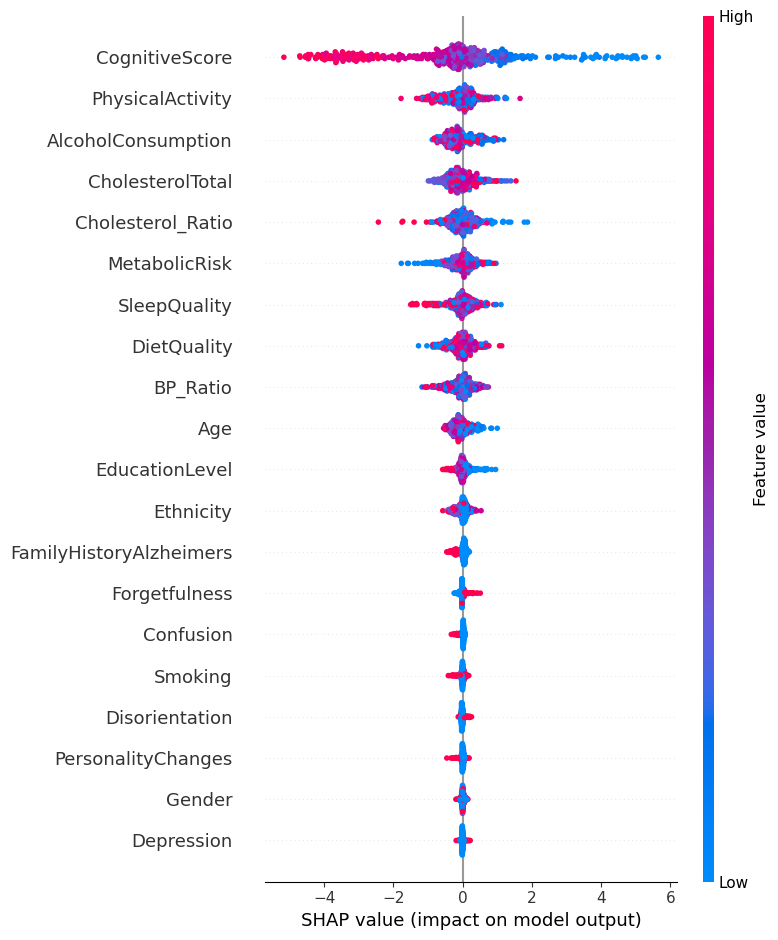

In [5]:
# SHAP Plot
# SHAP displays feature prediction contribution per sample
# library needed to display and create the plot
import shap
# detects XGBoost model 
# builds an explainer that understands model function
explainer = shap.Explainer(xgb_model)
# SHAP value calculations
shap_values = explainer(X_test_stat)
# visualization of plot
shap.summary_plot(shap_values, X_test_stat)

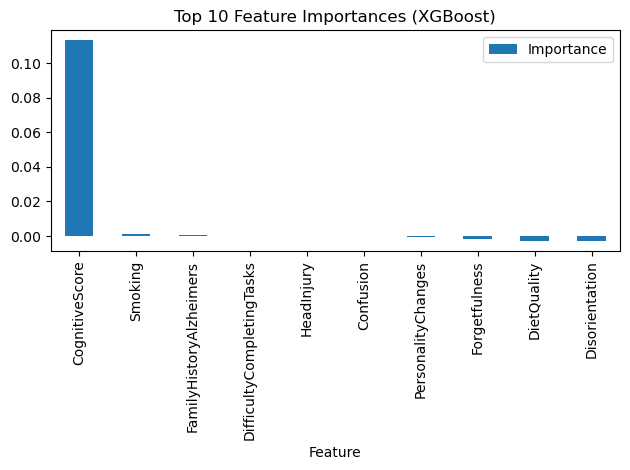

In [6]:
# Bar Chart of Top 10 features that are the most important per the XGBoost algorithm
# permutation importance based
importance_df.sort_values("Importance", ascending=False).head(10).plot.bar(x='Feature', y='Importance')
plt.title("Top 10 Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()

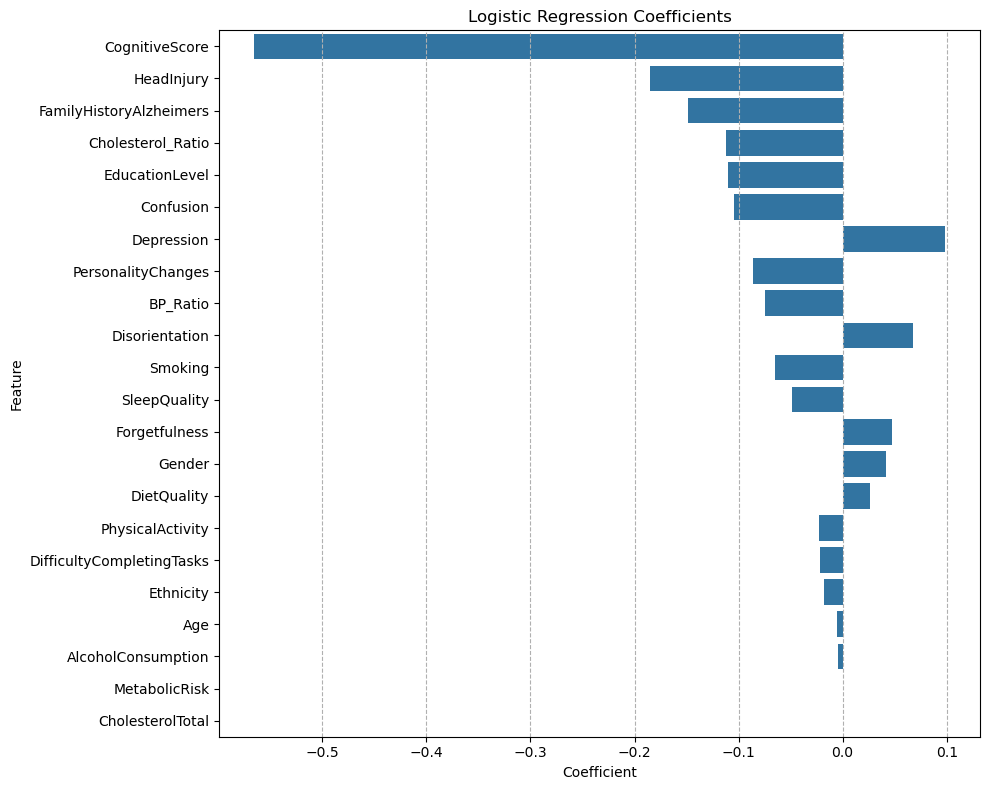

In [7]:
# libraries needed for plot
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Coefficient extraction
# skips intercept
# reflects log-odds predicted probability influence per feature
coefficients = result.params.drop('const', errors='ignore')
feature_names = coefficients.index
coef_values = coefficients.values

# Dataframe creation for plotting purposes
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coef_values})

# Coefficient Magnitude Sorting
# aids in visualization
coef_df['Abs_Coefficient'] = abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Color Setting Based on Coefficient Sign
# psotive coefficent = increase probabilty 
# negative coefficent = decrease probabilty 
colors = ['#4c72b0' if coef > 0 else '#dd8452' for coef in coef_df['Coefficient']]
cmap = plt.cm.coolwarm 
norm = plt.Normalize(vmin=coef_df['Coefficient'].min(), vmax=coef_df['Coefficient'].max())
scalarMap = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
colors_mapped = [scalarMap.to_rgba(c) for c in coef_df['Coefficient']]

# Horizontal Bar Chart Figure Configurations 
plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=coef_df)
plt.title('Logistic Regression Coefficients')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--')
plt.tight_layout()
plt.show()


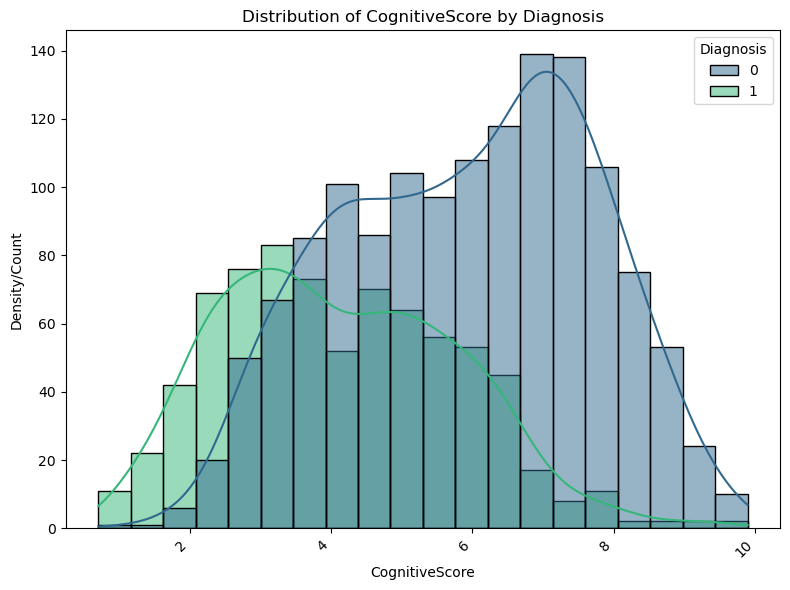

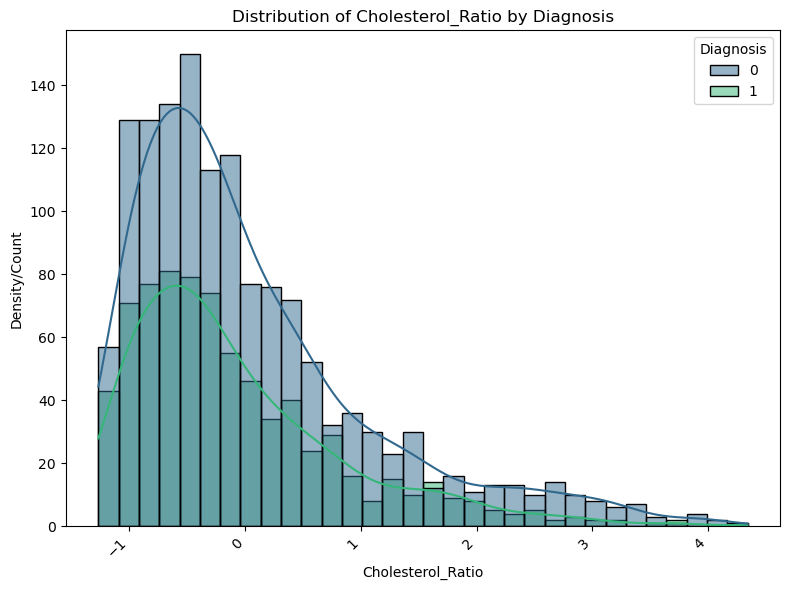

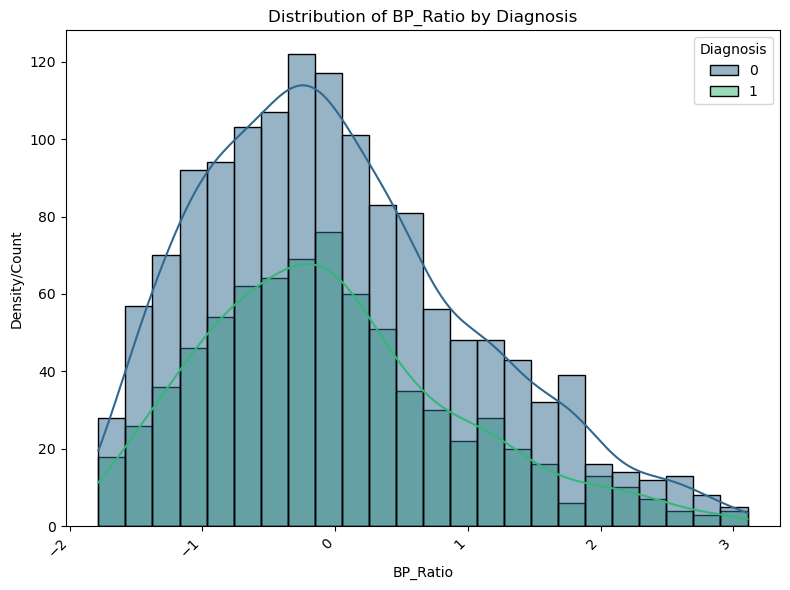

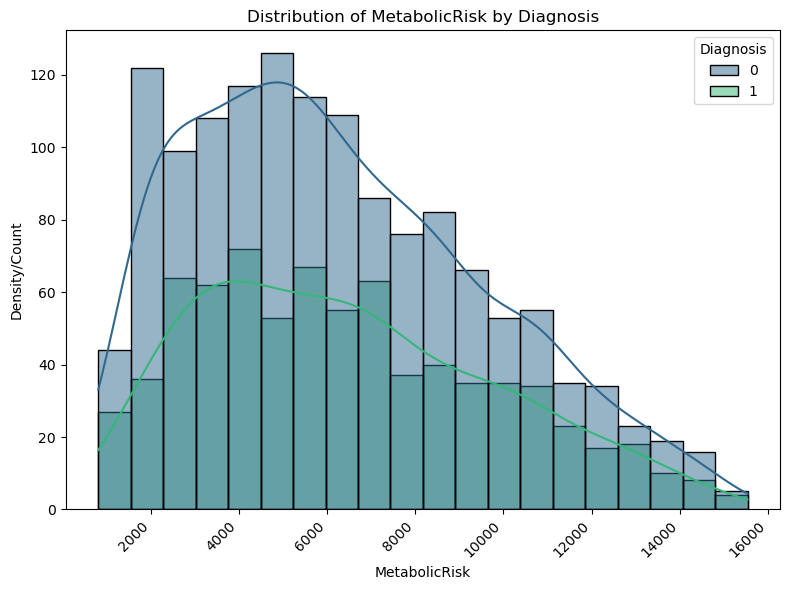

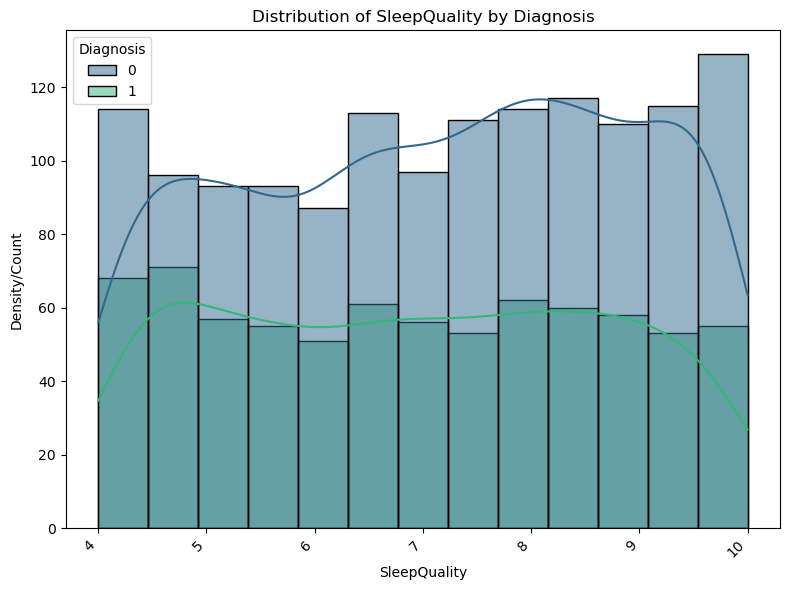

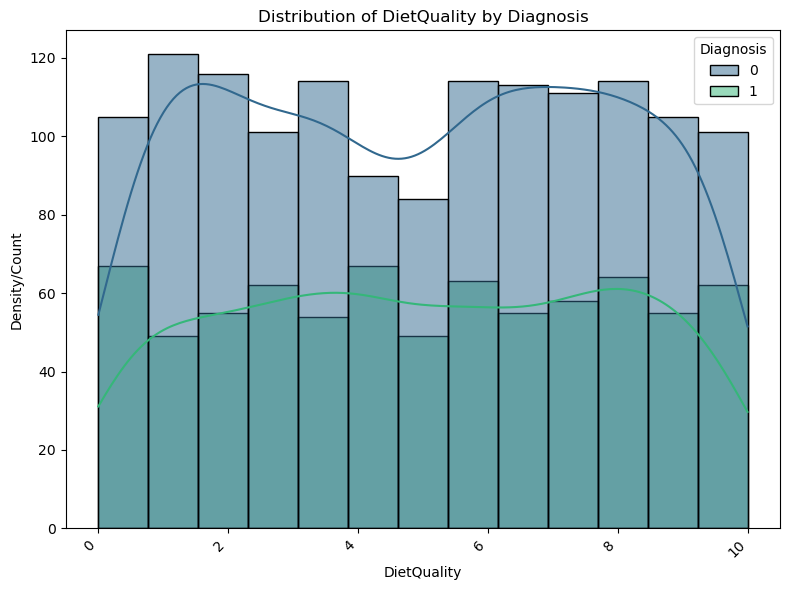

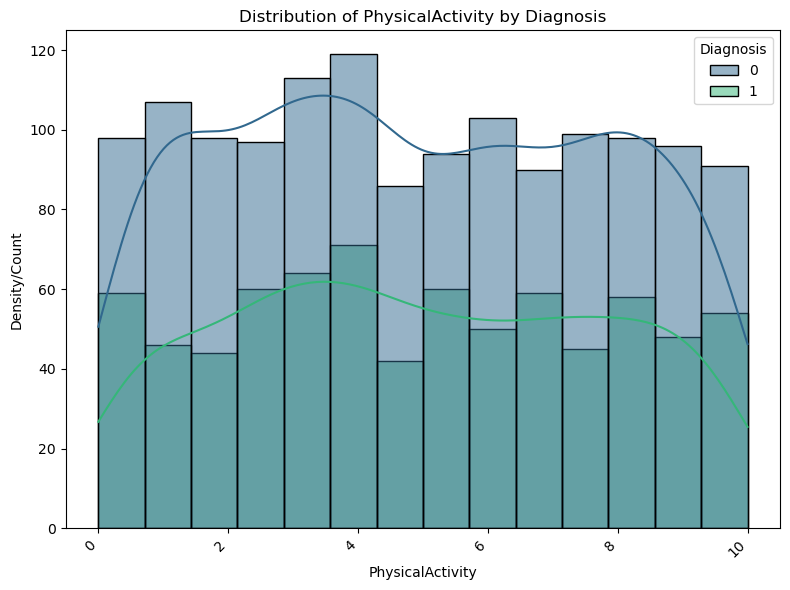

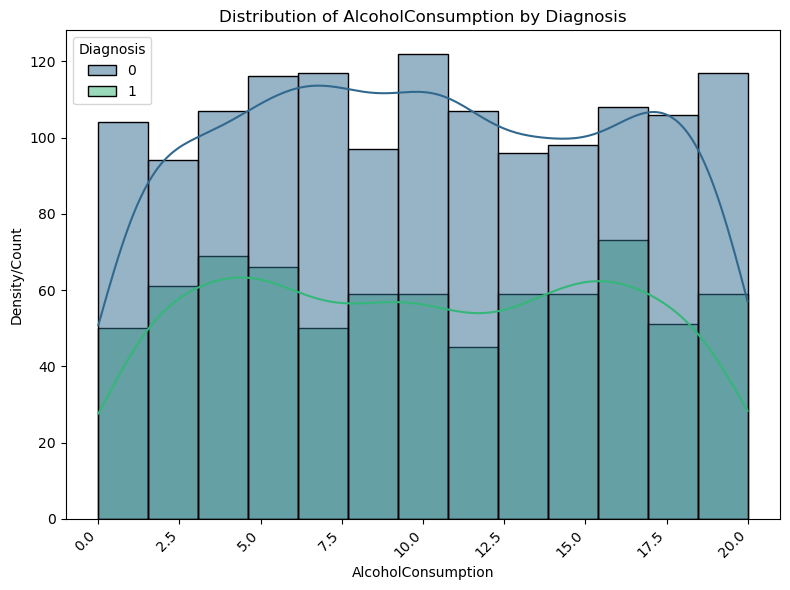

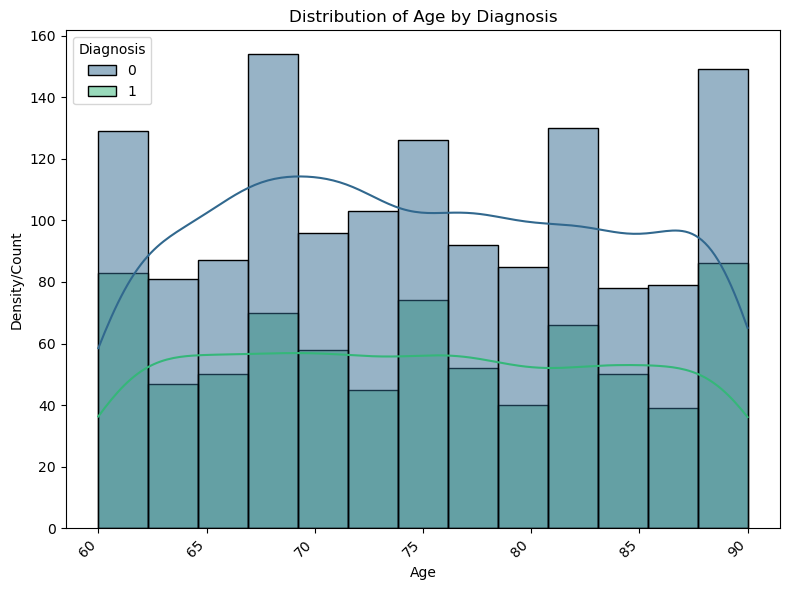

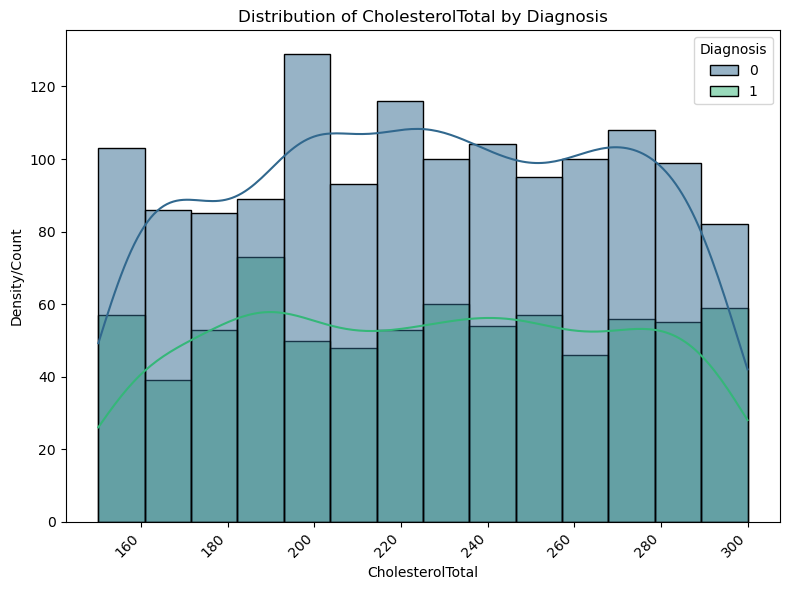

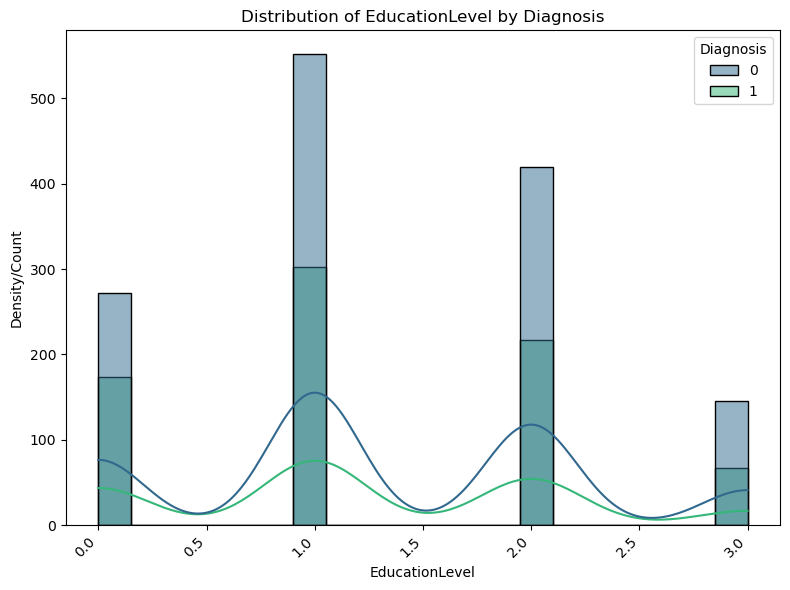

C:\Users\madis\AppData\Local\Temp\ipykernel_3272\1653215746.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Diagnosis', y=feature, data=Alzheimers, palette='viridis')


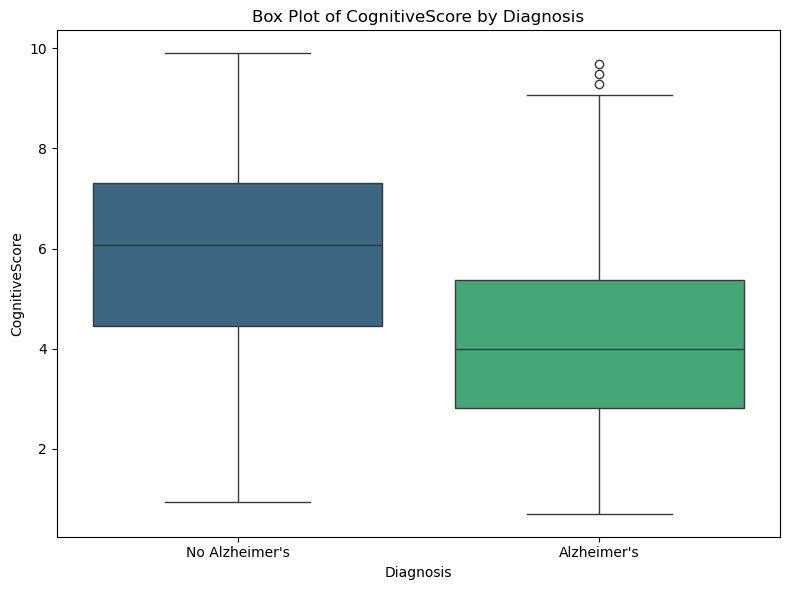

C:\Users\madis\AppData\Local\Temp\ipykernel_3272\1653215746.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Diagnosis', y=feature, data=Alzheimers, palette='viridis')


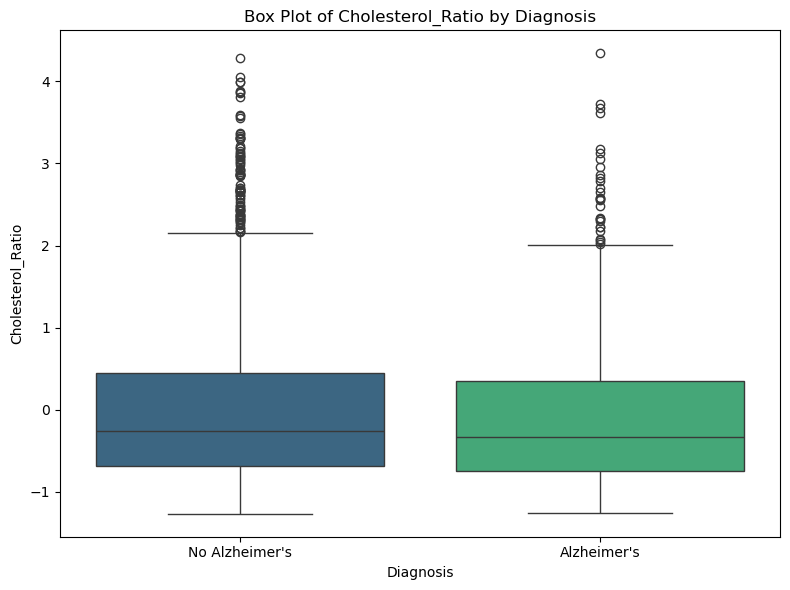

C:\Users\madis\AppData\Local\Temp\ipykernel_3272\1653215746.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Diagnosis', y=feature, data=Alzheimers, palette='viridis')


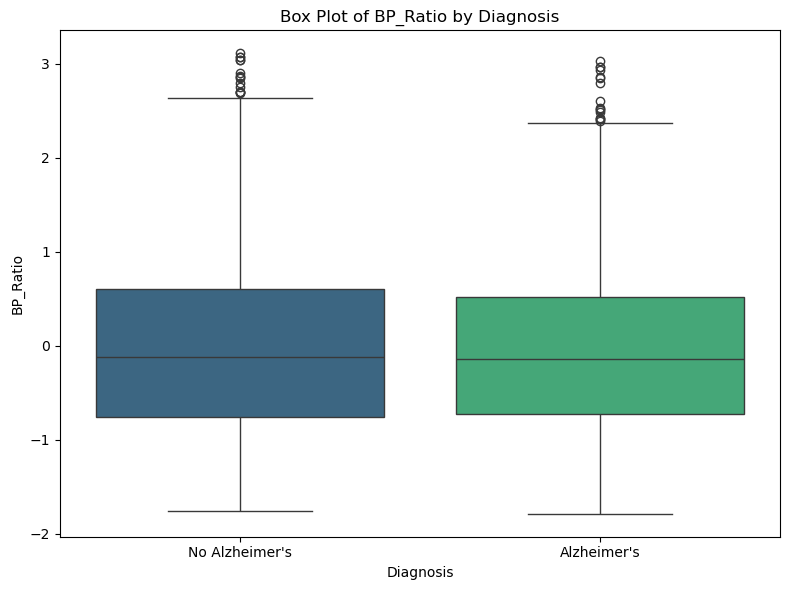

C:\Users\madis\AppData\Local\Temp\ipykernel_3272\1653215746.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Diagnosis', y=feature, data=Alzheimers, palette='viridis')


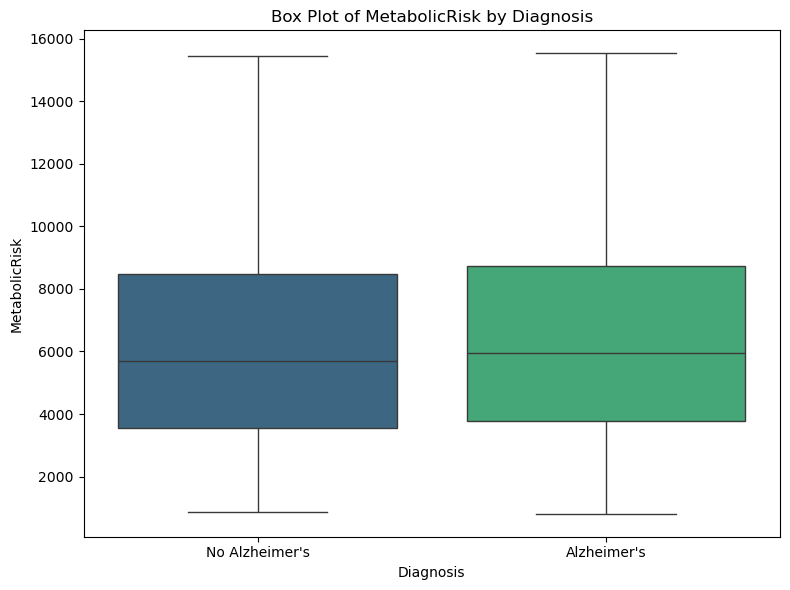

C:\Users\madis\AppData\Local\Temp\ipykernel_3272\1653215746.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Diagnosis', y=feature, data=Alzheimers, palette='viridis')


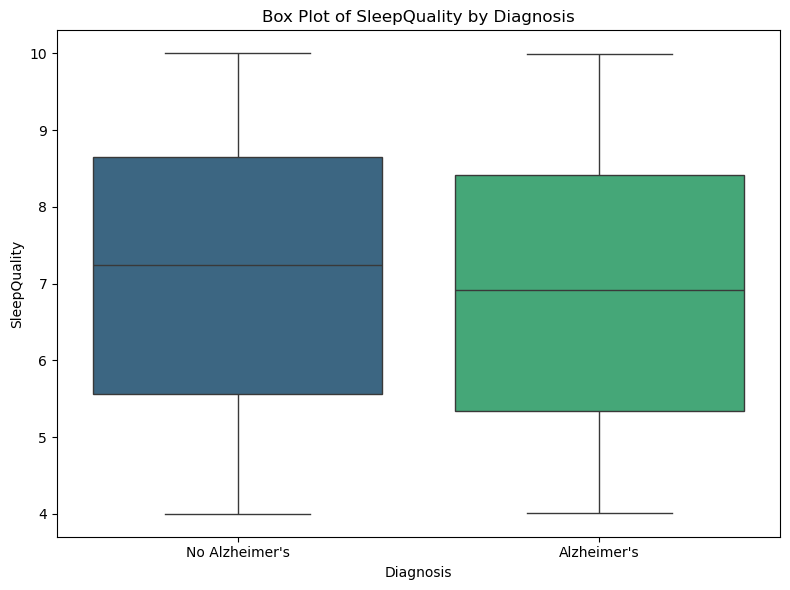

C:\Users\madis\AppData\Local\Temp\ipykernel_3272\1653215746.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Diagnosis', y=feature, data=Alzheimers, palette='viridis')


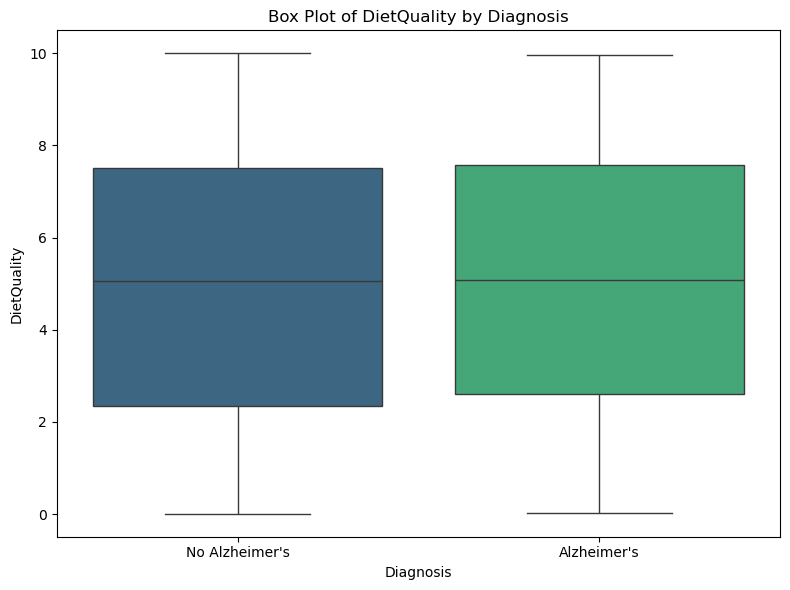

C:\Users\madis\AppData\Local\Temp\ipykernel_3272\1653215746.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Diagnosis', y=feature, data=Alzheimers, palette='viridis')


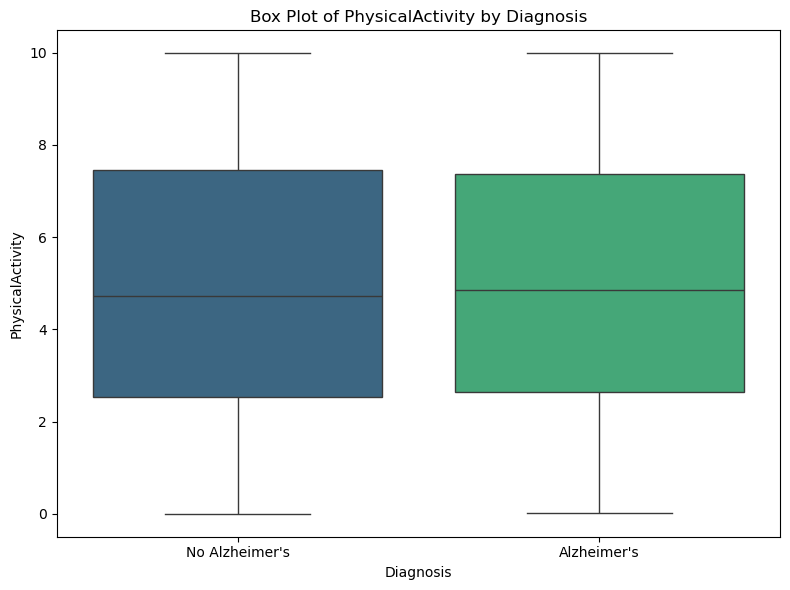

C:\Users\madis\AppData\Local\Temp\ipykernel_3272\1653215746.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Diagnosis', y=feature, data=Alzheimers, palette='viridis')


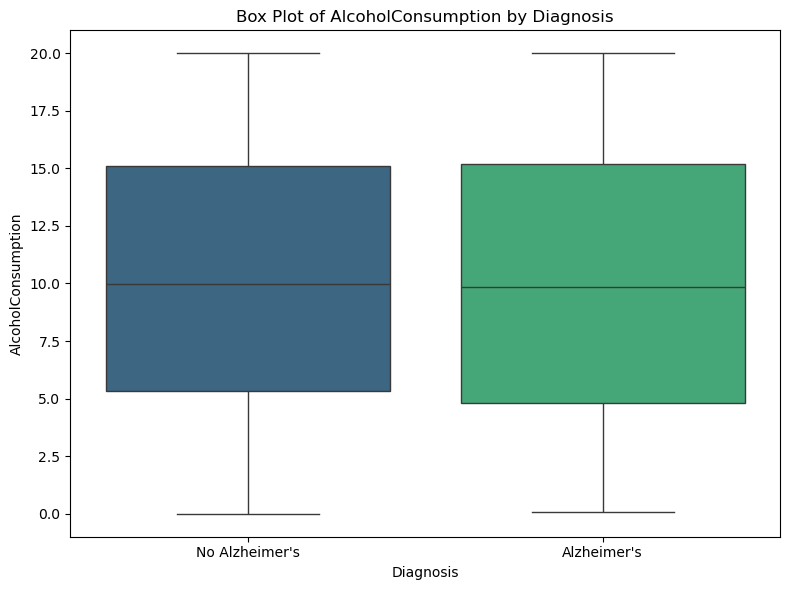

C:\Users\madis\AppData\Local\Temp\ipykernel_3272\1653215746.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Diagnosis', y=feature, data=Alzheimers, palette='viridis')


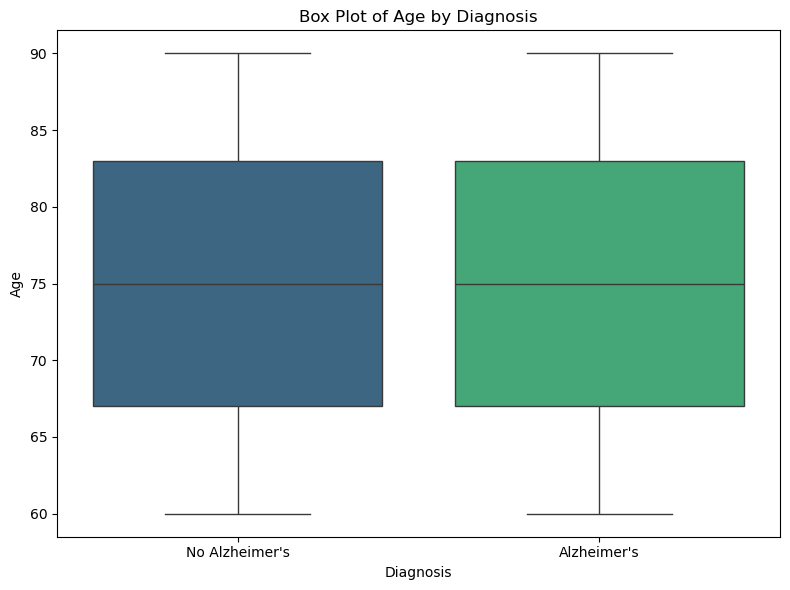

C:\Users\madis\AppData\Local\Temp\ipykernel_3272\1653215746.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Diagnosis', y=feature, data=Alzheimers, palette='viridis')


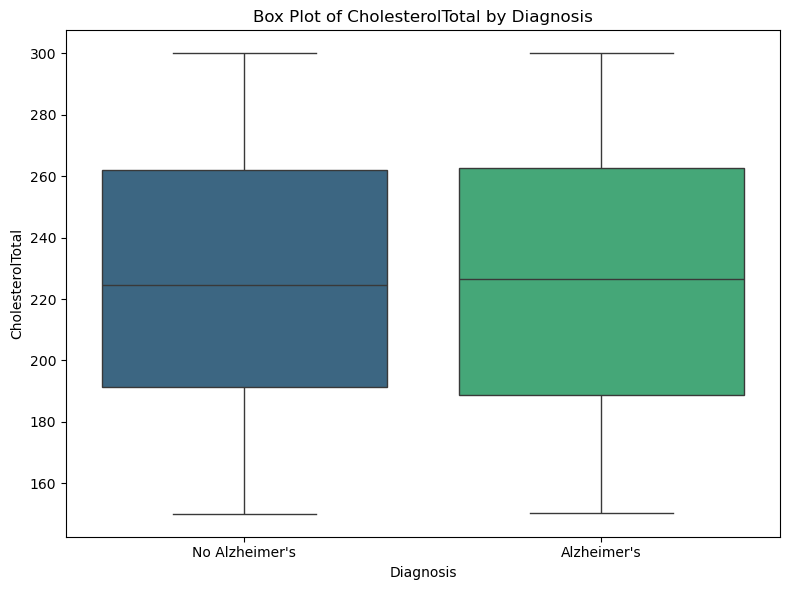

C:\Users\madis\AppData\Local\Temp\ipykernel_3272\1653215746.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Diagnosis', y=feature, data=Alzheimers, palette='viridis')


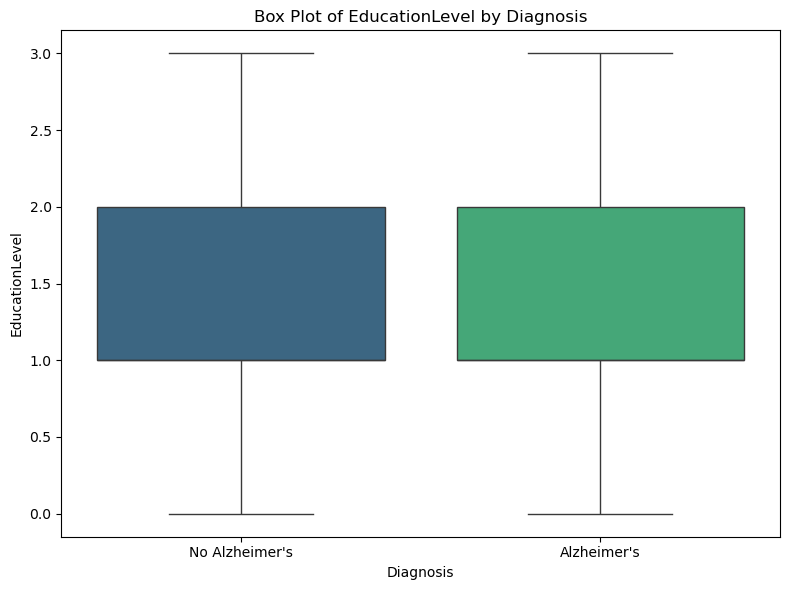

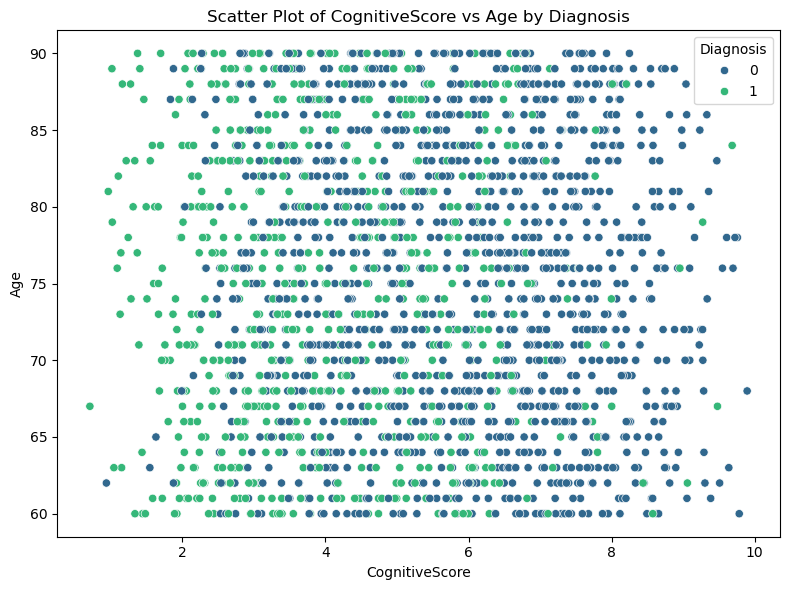

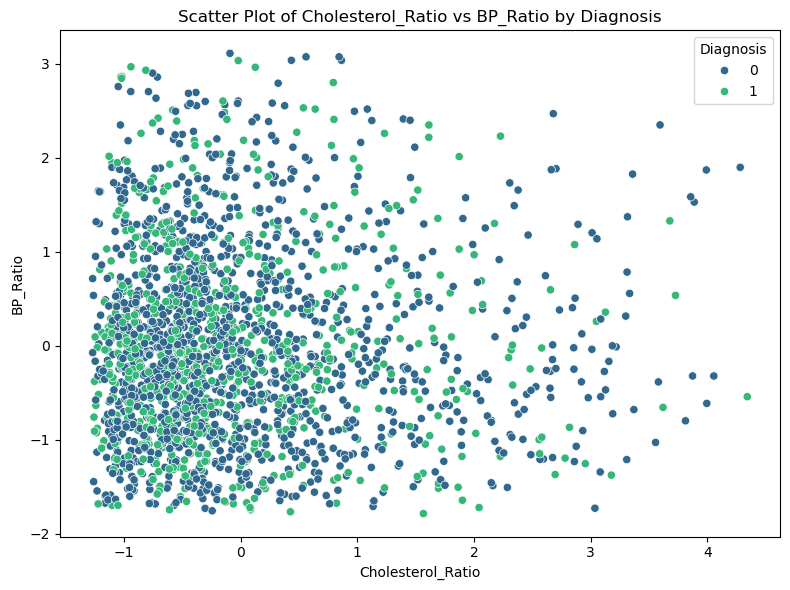

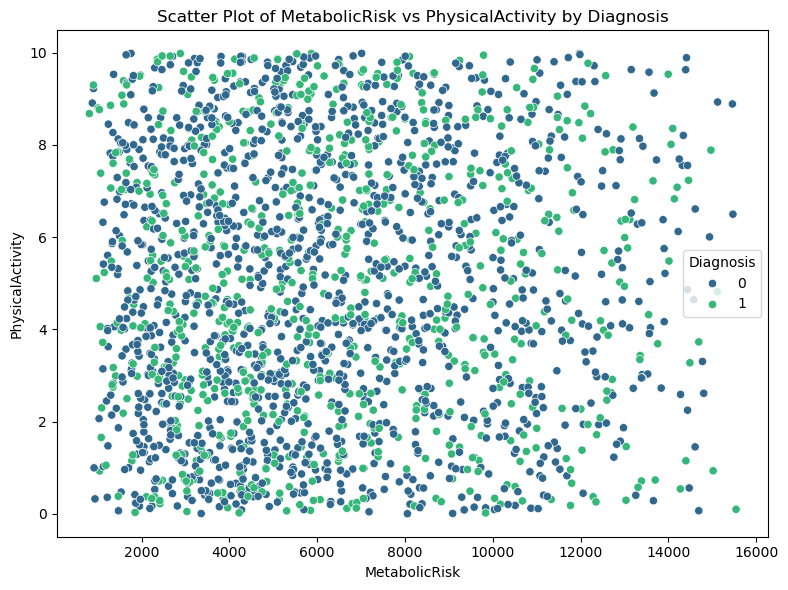

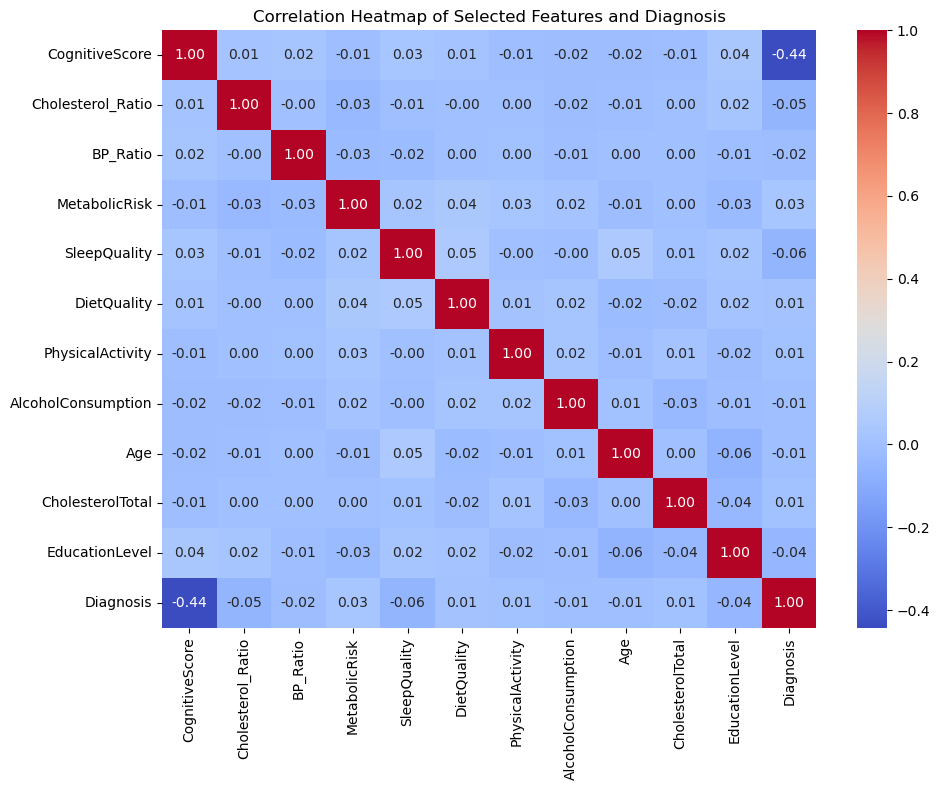

C:\Users\madis\AppData\Local\Temp\ipykernel_3272\1653215746.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Diagnosis', y=feature, data=Alzheimers, palette='viridis')


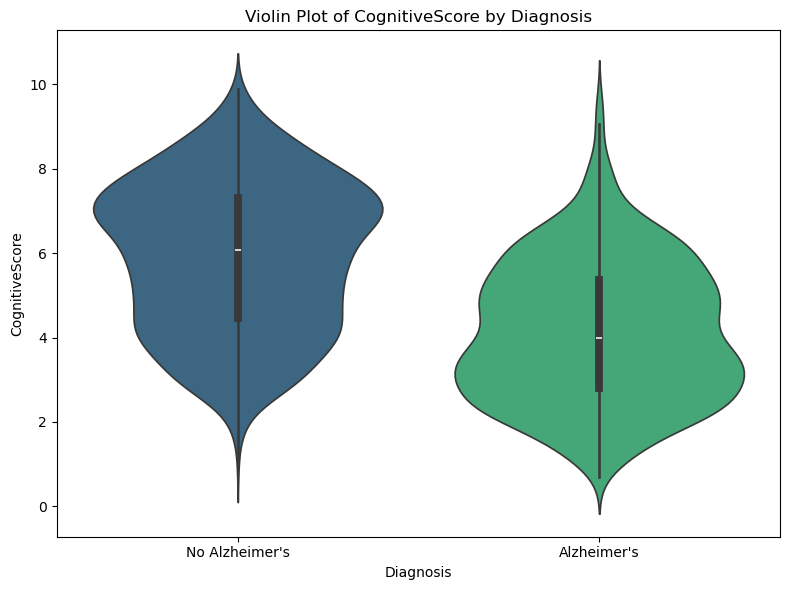

C:\Users\madis\AppData\Local\Temp\ipykernel_3272\1653215746.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Diagnosis', y=feature, data=Alzheimers, palette='viridis')


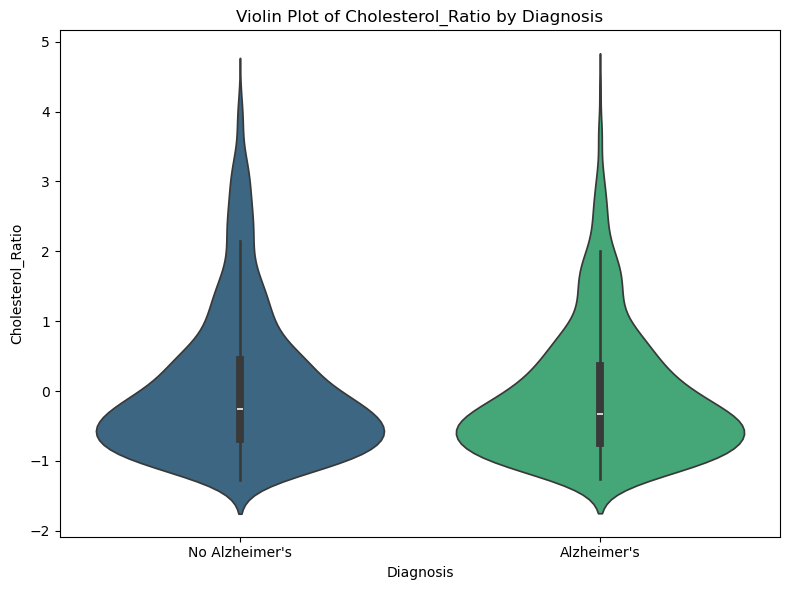

C:\Users\madis\AppData\Local\Temp\ipykernel_3272\1653215746.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Diagnosis', y=feature, data=Alzheimers, palette='viridis')


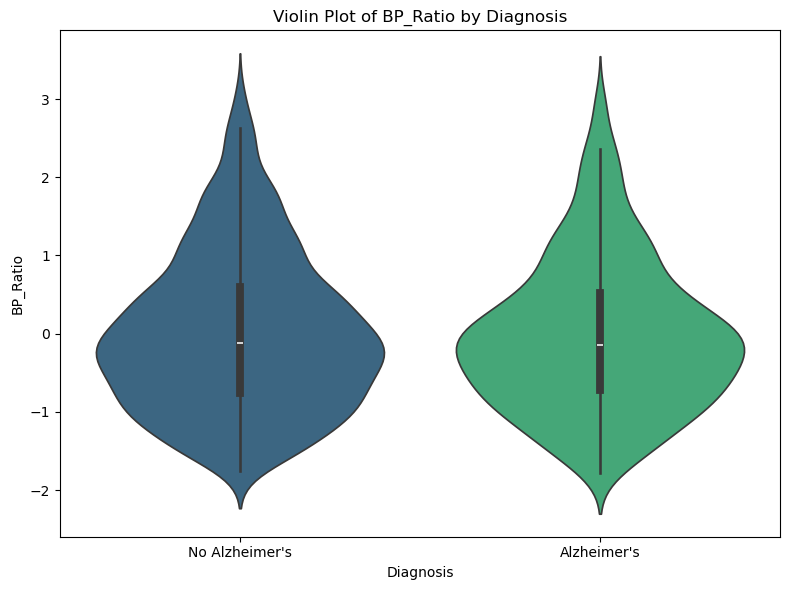

C:\Users\madis\AppData\Local\Temp\ipykernel_3272\1653215746.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Diagnosis', y=feature, data=Alzheimers, palette='viridis')


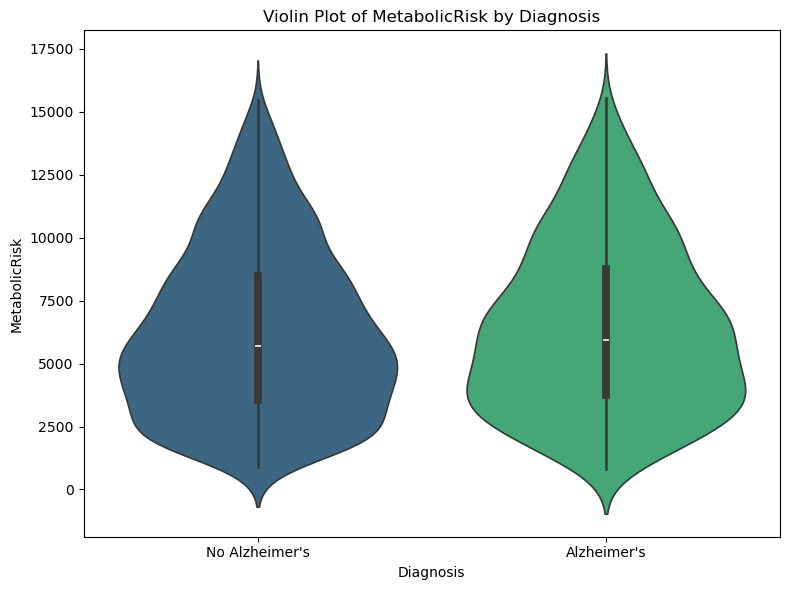

C:\Users\madis\AppData\Local\Temp\ipykernel_3272\1653215746.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Diagnosis', y=feature, data=Alzheimers, palette='viridis')


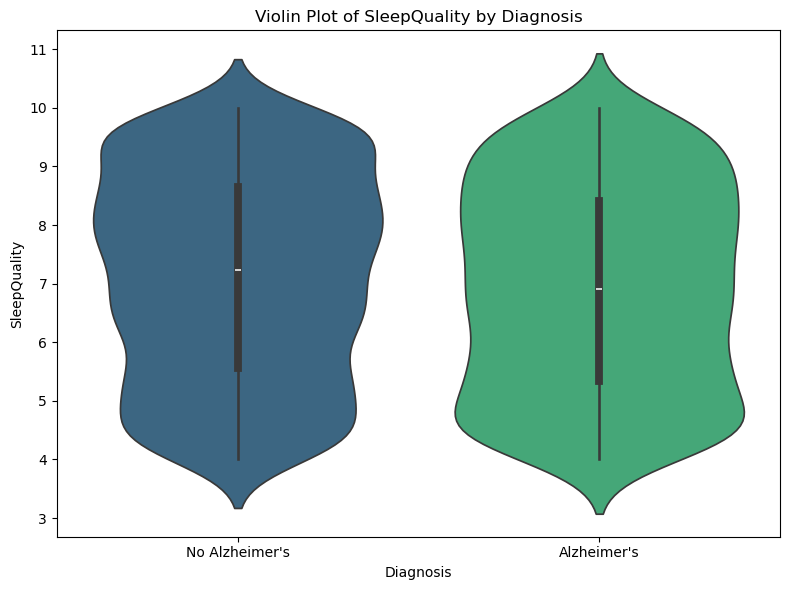

C:\Users\madis\AppData\Local\Temp\ipykernel_3272\1653215746.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Diagnosis', y=feature, data=Alzheimers, palette='viridis')


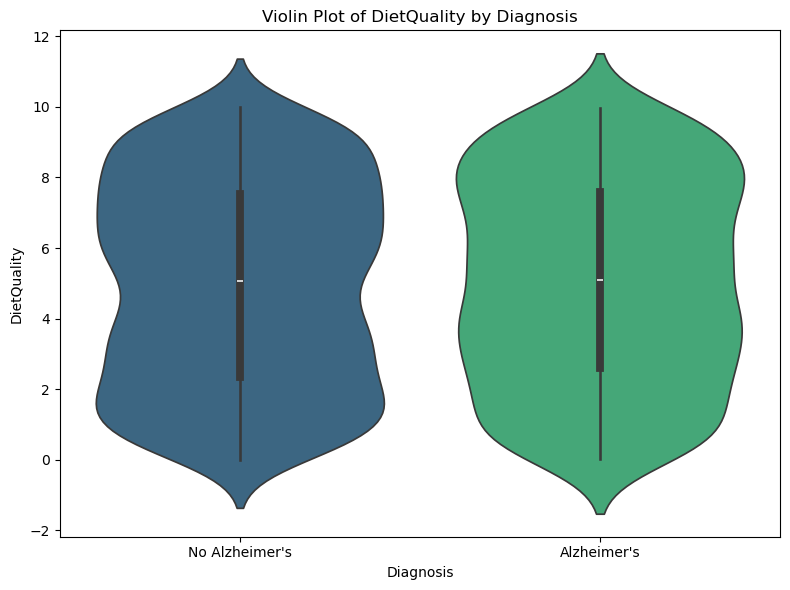

C:\Users\madis\AppData\Local\Temp\ipykernel_3272\1653215746.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Diagnosis', y=feature, data=Alzheimers, palette='viridis')


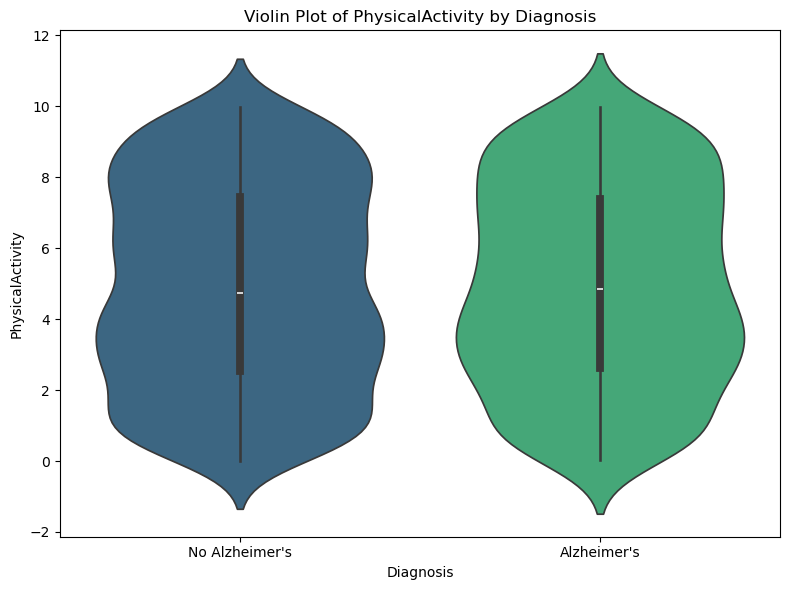

C:\Users\madis\AppData\Local\Temp\ipykernel_3272\1653215746.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Diagnosis', y=feature, data=Alzheimers, palette='viridis')


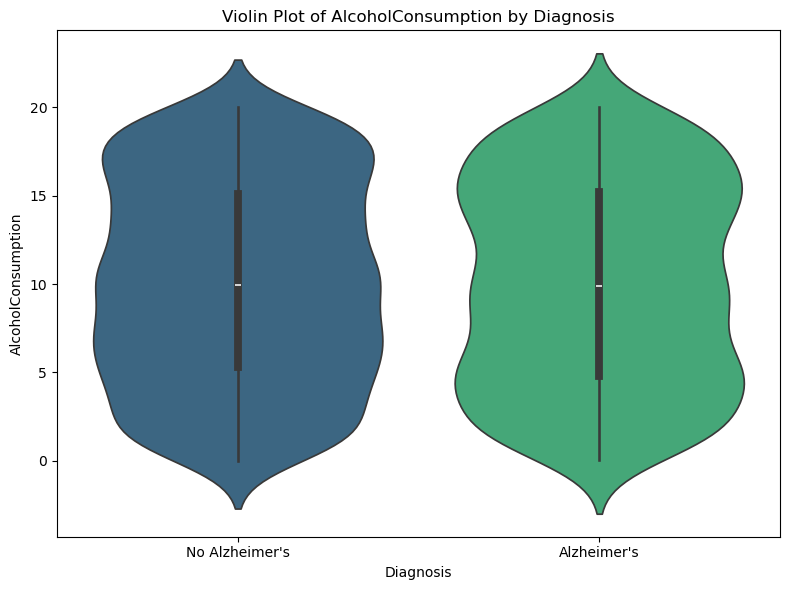

C:\Users\madis\AppData\Local\Temp\ipykernel_3272\1653215746.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Diagnosis', y=feature, data=Alzheimers, palette='viridis')


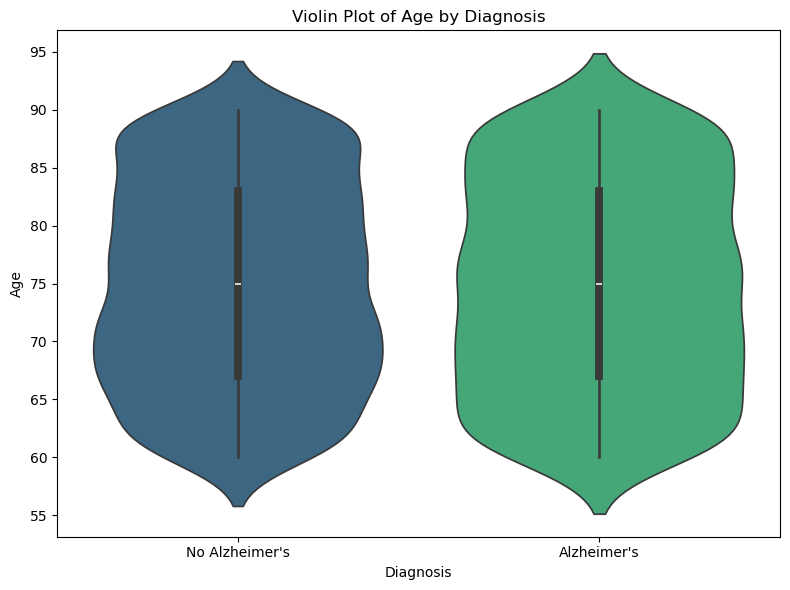

C:\Users\madis\AppData\Local\Temp\ipykernel_3272\1653215746.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Diagnosis', y=feature, data=Alzheimers, palette='viridis')


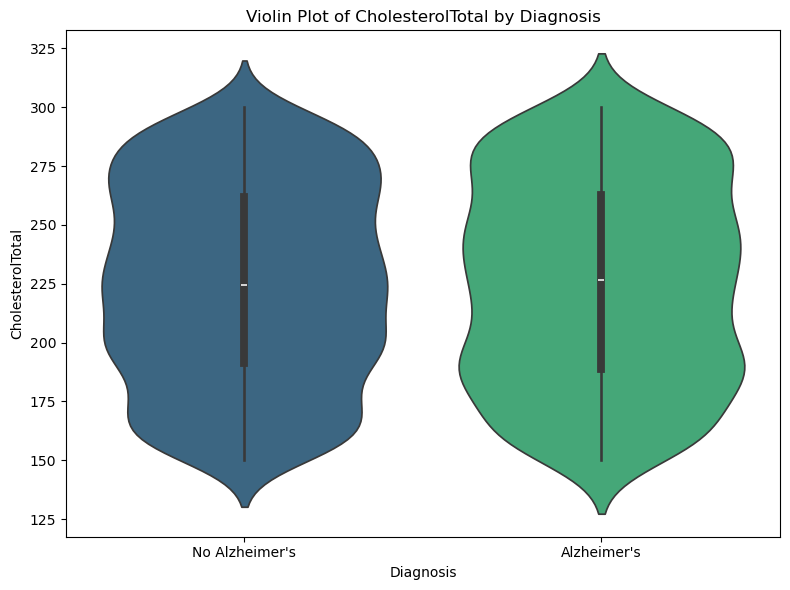

C:\Users\madis\AppData\Local\Temp\ipykernel_3272\1653215746.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Diagnosis', y=feature, data=Alzheimers, palette='viridis')


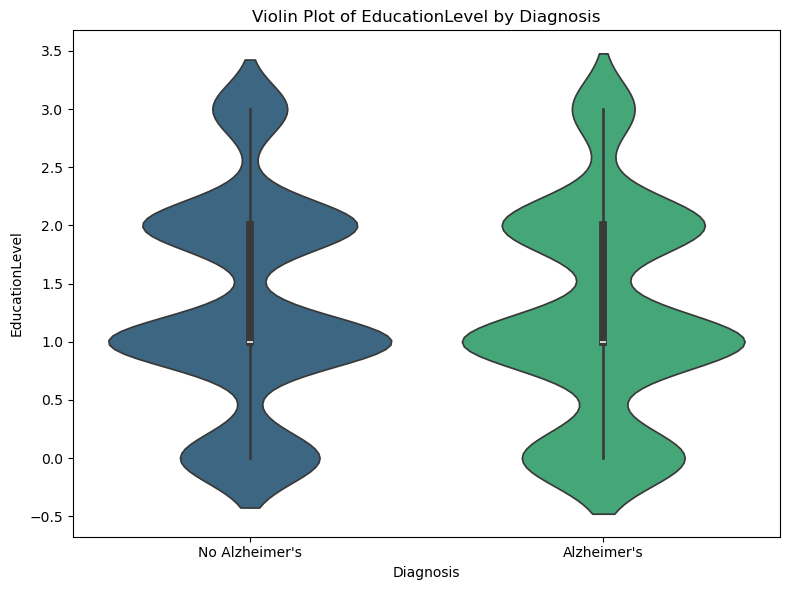

In [28]:
# libraries needed for plots
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Features selected to be plotted
# Seen the most across the model algorithms 
selected_features = [
    'CognitiveScore',
    'Cholesterol_Ratio',
    'BP_Ratio',
    'MetabolicRisk',
    'SleepQuality',
    'DietQuality',
    'PhysicalActivity',
    'AlcoholConsumption',
    'Age',
    'CholesterolTotal', 
]

# Distribution Plots per Feature by Diagnosis 
for feature in selected_features:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=Alzheimers, x=feature, hue='Diagnosis', kde=True, palette='viridis')
    plt.title(f'Distribution of {feature} by Diagnosis')
    plt.xlabel(feature)
    plt.ylabel('Density/Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Box Plots per Feature by Diagnosis
for feature in selected_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Diagnosis', y=feature, data=Alzheimers, palette='viridis')
    plt.xticks([0, 1], ['No Alzheimer\'s', 'Alzheimer\'s'])
    plt.title(f'Box Plot of {feature} by Diagnosis')
    plt.ylabel(feature)
    plt.xlabel('Diagnosis')
    plt.tight_layout()
    plt.show()

# Scatter Plots
# Diagnosis set as a color feature 
# set for continuous feature pairs
# select prime features selected for visualization
pair_plots = [
    ('CognitiveScore', 'Age'),
    ('Cholesterol_Ratio', 'BP_Ratio'),
    ('MetabolicRisk', 'PhysicalActivity')
]

for feature1, feature2 in pair_plots:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=feature1, y=feature2, hue='Diagnosis', data=Alzheimers, palette='viridis')
    plt.title(f'Scatter Plot of {feature1} vs {feature2} by Diagnosis')
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.tight_layout()
    plt.show()

# Correlation Heatmap of Selected Features and Diagnosis
correlation_matrix = Alzheimers[selected_features + ['Diagnosis']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Selected Features and Diagnosis')
plt.tight_layout()
plt.show()

# Violin Plots
for feature in selected_features:
    plt.figure(figsize=(8, 6))
    sns.violinplot(x='Diagnosis', y=feature, data=Alzheimers, palette='viridis')
    plt.xticks([0, 1], ['No Alzheimer\'s', 'Alzheimer\'s'])
    plt.title(f'Violin Plot of {feature} by Diagnosis')
    plt.ylabel(feature)
    plt.xlabel('Diagnosis')
    plt.tight_layout()
    plt.show()


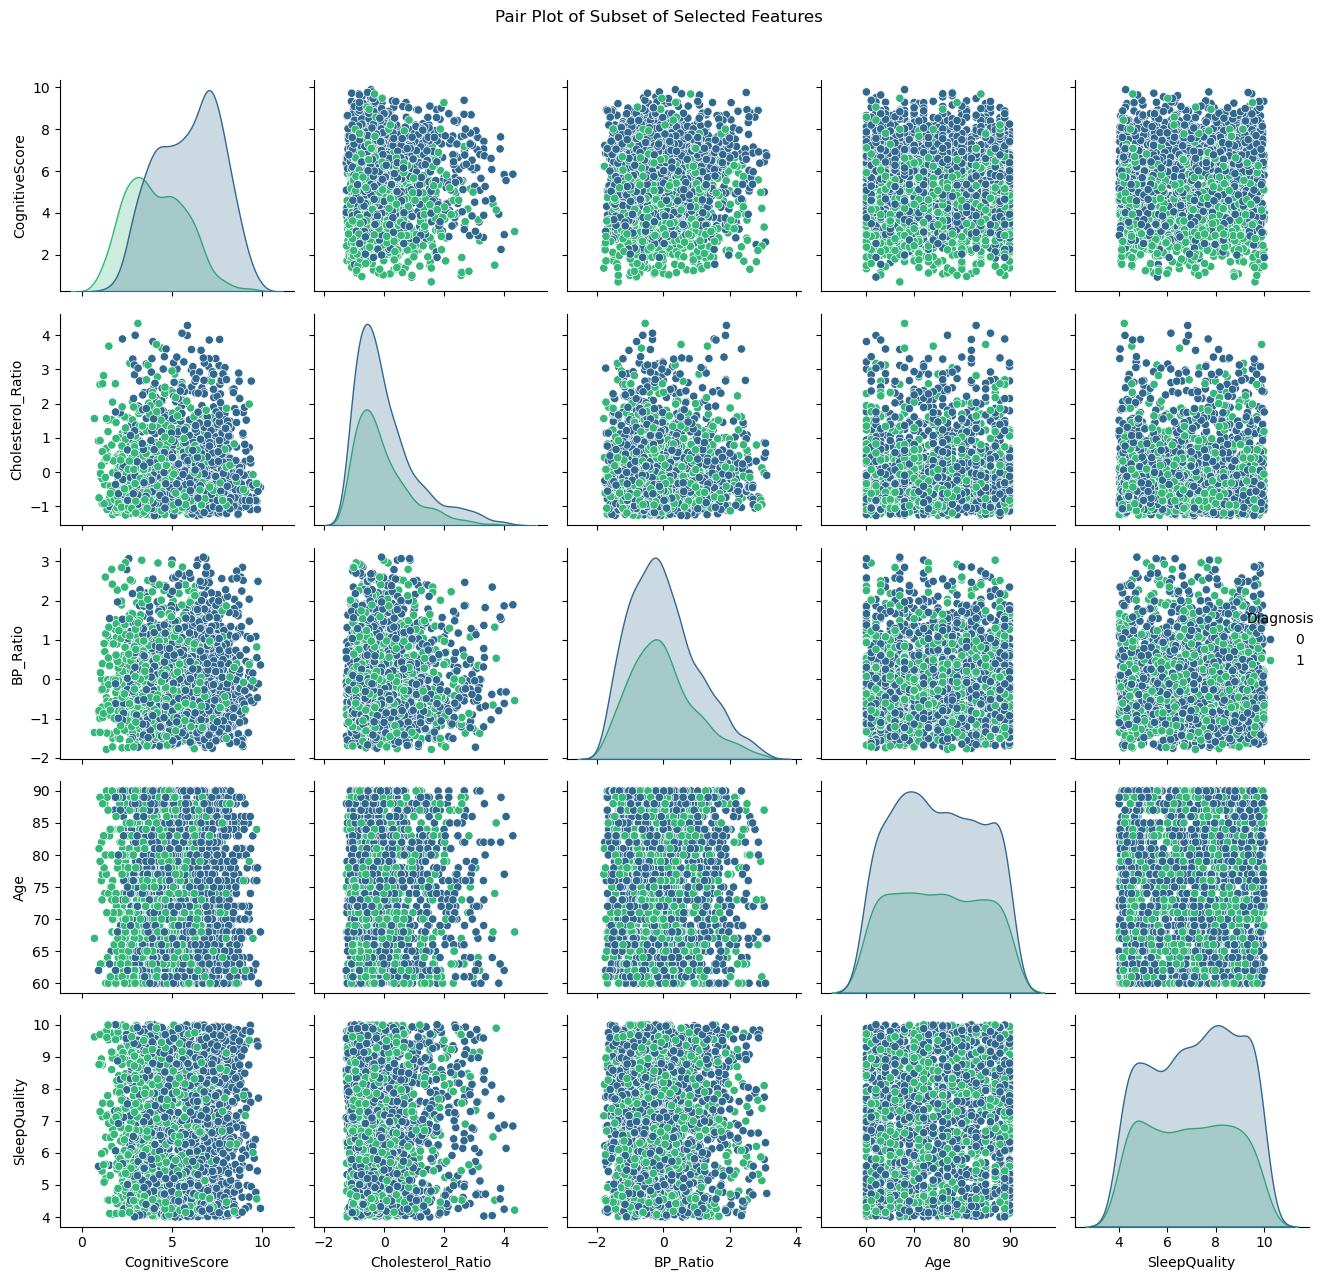

In [29]:
# Pair Plot
# subset of isolated features
# seen in majority of models; high in relevance + importance
subset_selected_features = [
    'CognitiveScore',
    'Cholesterol_Ratio',
    'BP_Ratio',
    'Age',
    'Diagnosis'
]
# figure configurations
sns.pairplot(Alzheimers[subset_selected_features], hue='Diagnosis', palette='viridis')
plt.suptitle('Pair Plot of Subset of Selected Features', y=1.02)
plt.tight_layout()
plt.show()

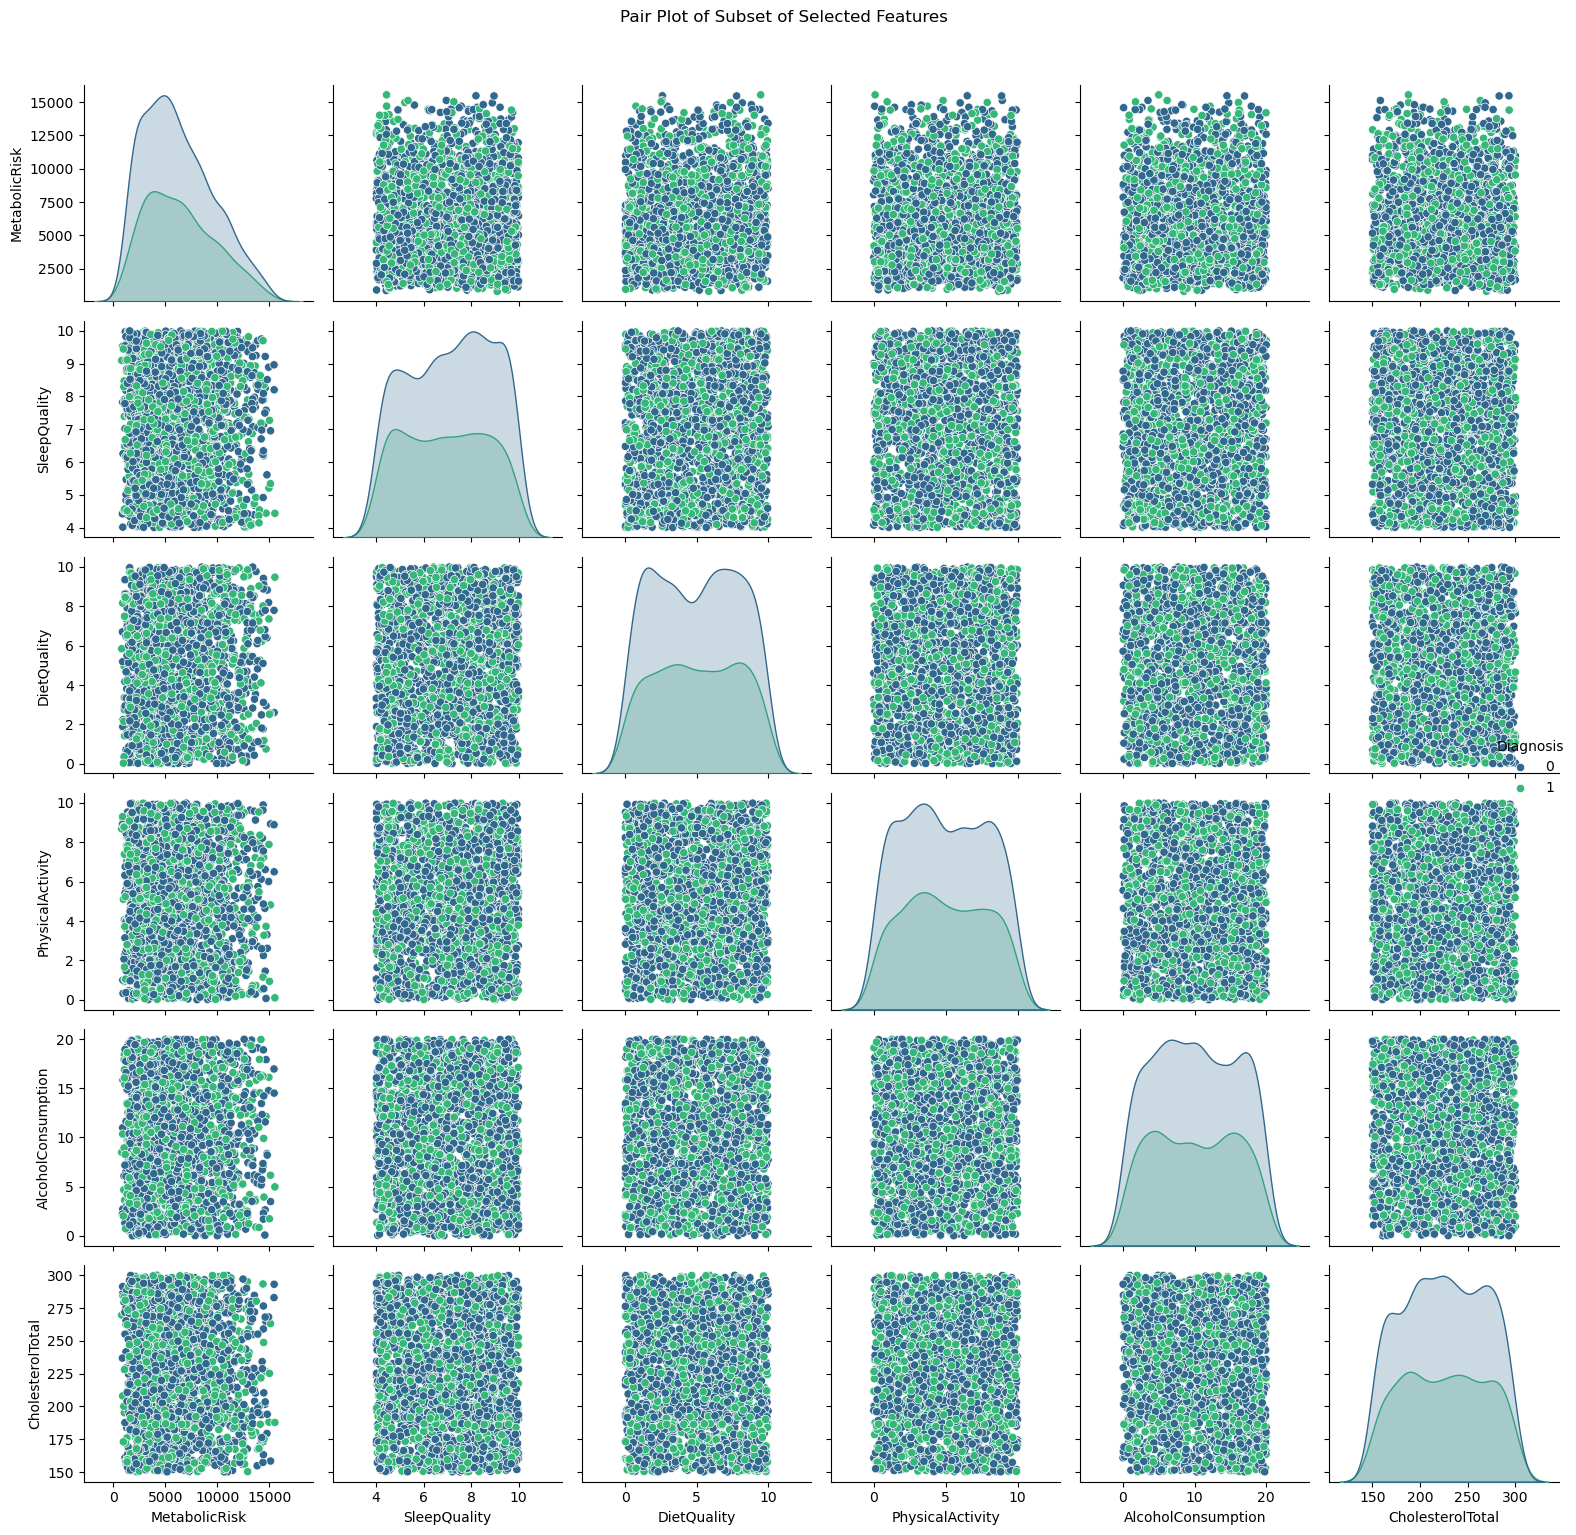

In [30]:
# Pair Plot
# subset of isolated features
# not seen in as many features, but still relevant
sub_features = [
    'MetabolicRisk',
    'SleepQuality',
    'DietQuality',
    'PhysicalActivity',
    'AlcoholConsumption',
    'CholesterolTotal', 
    'Diagnosis'
]
# figure configurations
sns.pairplot(Alzheimers[sub_features], hue='Diagnosis', palette='viridis')
plt.suptitle('Pair Plot of Subset of Selected Features', y=1.02)
plt.tight_layout()
plt.show()